In [1]:
import pickle
with open("../../circuit.pickle", 'rb') as handle:
    qc = pickle.load(handle)

In [2]:
calibrations = qc.calibrations
rzx_cal = calibrations['rzx']
rx_cal = calibrations['rx']

In [3]:
rx_cal.keys()

dict_keys([((0,), (0.3333333328625214,)), ((3,), (0.3333333328625215,)), ((1,), (0.33333333507070523,)), ((2,), (0.33333333507070523,))])

In [4]:
type(list(rx_cal.values())[0])

qiskit.pulse.schedule.ScheduleBlock

In [5]:
custom_rx_sched = list(rx_cal.values())[0]
print(custom_rx_sched)

ScheduleBlock(Play(Drag(duration=160, sigma=40, beta=-0.44959049003489476, amp=0.01726511975439483, angle=0), DriveChannel(0)), name="rx(0.333)", transform=AlignLeft())


In [6]:
from qiskit import QuantumCircuit
import numpy as np

circuit = QuantumCircuit(1, name='custom_rx')
circuit.rx(0,0)
custom_rx = circuit.to_gate()

In [7]:
from qiskit_ibm_runtime import QiskitRuntimeService
import numpy as np
from qiskit import QuantumCircuit, transpile
from qiskit.transpiler import InstructionProperties
from qiskit_ibm_provider import IBMProvider
from qiskit_experiments.library import InterleavedRB

In [8]:
#Setting the IBM provider
api_file = "../../../ibm_API_key"
with open(api_file, "r") as f:
        api_key = f.readline().strip()
provider = IBMProvider(api_key, instance='ibm-q-ncsu/nc-state/quantum-compiler')
backend = provider.get_backend('ibmq_mumbai')

In [9]:
backend.target.add_instruction(custom_rx, {(0,): InstructionProperties(calibration=custom_rx_sched)})

In [10]:
lengths = np.arange(1, 200, 30)
num_samples = 10
seed = 1010
qubits = [0] # make sure it is the qubit added in the backend target

int_exp = InterleavedRB(
    custom_rx, qubits, lengths, num_samples=num_samples, seed=seed, backend=backend)

In [11]:
int_expdata = int_exp.run(backend).block_for_results()
int_results = int_expdata.analysis_results()

/Users/amey/anaconda3/envs/simuq/lib/python3.10/site-packages/qiskit_ibm_provider/ibm_backend.py:447: UserWarning: The backend ibmq_mumbai is currently paused.
  warnings.warn(f"The backend {self.name} is currently paused.")


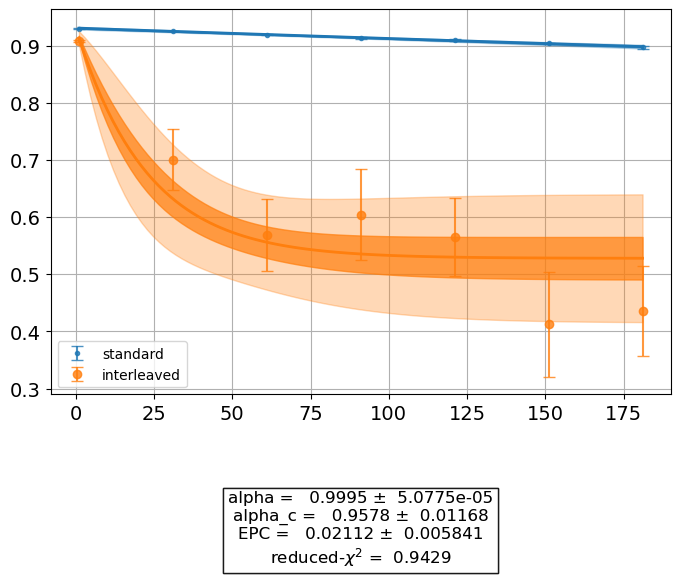

AnalysisResult
- name: @Parameters_InterleavedRBAnalysis
- value: CurveFitResult:
 - fitting method: least_squares
 - number of sub-models: 2
  * F_standard(x) = a * alpha ** x + b
  * F_interleaved(x) = a * (alpha_c * alpha) ** x + b
 - success: True
 - number of function evals: 80
 - degree of freedom: 10
 - chi-square: 9.429478376143592
 - reduced chi-square: 0.9429478376143592
 - Akaike info crit.: 2.4669683019449575
 - Bayesian info crit.: 5.023197620405991
 - init params:
  * a = 0.42203005692246504
  * alpha = 0.9995546692637177
  * b = 0.5
  * alpha_c = 0.9853367470945457
 - fit params:
  * a = 0.40271228997901926 ± 0.0374208656767959
  * alpha = 0.9995358663582016 ± 5.0775184017076067e-05
  * b = 0.5279148489717005 ± 0.037455175421042305
  * alpha_c = 0.9577605947071044 ± 0.011682572392455426
 - correlations:
  * (a, b) = -0.9997968589204845
  * (alpha, b) = -0.8951773932777122
  * (b, alpha_c) = -0.6045310255313323
  * (alpha, alpha_c) = 0.5714487276026454
  * (a, alpha_c) = 

In [12]:
# View result data
display(int_expdata.figure(0))
for result in int_results:
    print(result)

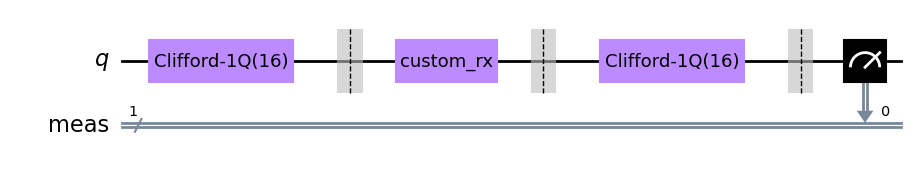

In [13]:
int_exp.circuits()[1].draw(output='mpl')

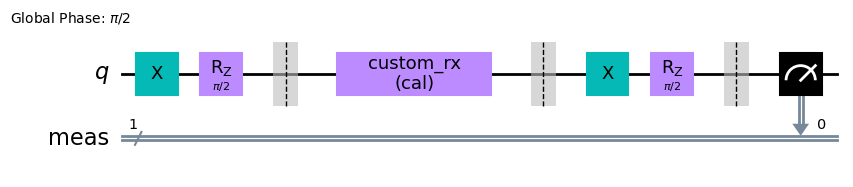

In [14]:
# you can see that the transpiled circuits contain the calibrations
int_exp._transpiled_circuits()[1].draw(output='mpl')